In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from statistics import mode

In [4]:
pretrained_model = "data/lenet_mnist_model.pth"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
model = Net().to(device)

In [7]:
# model.load_state_dict(torch.load(pretrained_model))
model.load_state_dict(torch.load(pretrained_model, map_location=torch.device('cpu')))

model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [8]:
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [9]:
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred_label = output.max(1, keepdim=True)[1]
    print(pred_label)
    print(data.size())
    break

tensor([[8]])
torch.Size([1, 1, 28, 28])


In [11]:
picture = data.squeeze().detach().cpu().numpy()

Target Label:  8
Predicted Label:  8


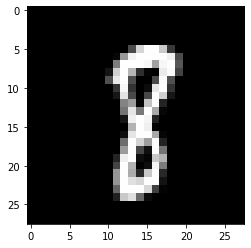

In [12]:
plt.imshow(picture, cmap='gray')
print("Target Label: ", target.item())
print("Predicted Label: ", pred_label.item())

In [13]:
fives = 0
for data, target in test_loader:
    if target.item() == 5:
        fives += 1

print(fives)

892


In [10]:
print(len(test_loader))

10000


In [17]:
?max

Docstring:
max(iterable, *[, default=obj, key=func]) -> value
max(arg1, arg2, *args, *[, key=func]) -> value

With a single iterable argument, return its biggest item. The
default keyword-only argument specifies an object to return if
the provided iterable is empty.
With two or more arguments, return the largest argument.
Type:      builtin_function_or_method


In [84]:
def test(model, device, test_loader, epsilon):
    correct = 0
    count = 0
    incorrect_fives = 0
    adv_examples = []
    classes = [[] for _ in range(10)]
    all_of_the_things = []
    all_the_other_things = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        
        init_pred = output.max(1, keepdim=True)[1]

        topVals, topIndices = torch.topk(output, 10)
        # print(topVals)
        # print(topIndices)
        # print(topIndices[0][1])
        # closest_class = topIndices[0][1].item()
        
        # BELOW IS ACTUALLY THE FURTHERST CLASS I JUST DIDN'T WANT TO RECODE EVERYTHING EVERYWHERE
        closest_class = topIndices[0][9].item()

        # print(closest_class)


        #If prediction is already wrong go to next item
        if init_pred.item() != target.item():
            continue

        all_of_the_things.append(init_pred.item())
        
        #Creates Adversarial Image
        for i in range(10):
            topVals, topIndices = torch.topk(output, 2)
            if topIndices[0][0].item() == closest_class:
                break
            closest_class = topIndices[0][1].item()
            loss = F.cross_entropy(output, torch.tensor([closest_class]).to(device))

            model.zero_grad()
            loss.backward()

            data_grad = data.grad.data.sign()

            perturbed_image = data - epsilon*data_grad

            perturbed_image = torch.clamp(perturbed_image, 0, 1)

            data = perturbed_image.clone().detach()
            
            data.requires_grad_()
            
            output = model(data)

            count += 1

        final_pred = output.max(1, keepdim=True)[1]

        #Adds adversarial examples if wrong
        if final_pred.item() == target.item():
            correct += 1

            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        
        else:
            # print(target.item())
            classes[init_pred.item()].append(final_pred.item())
            if final_pred.item() == closest_class:
                incorrect_fives += 1
            if len(adv_examples) < 5:
                adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        
        all_the_other_things.append(final_pred.item())

    final_acc = correct/float(len(test_loader))
    five_acc = incorrect_fives/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}\tPercent Misclassified as Closest Class = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc, incorrect_fives, len(test_loader), five_acc))

    # print(classes)
    result = []
    for item in classes:
        result.append(mode(item))
    
    print(result)
    # print(all_the_other_things)
    # print(all_of_the_things)

    return final_acc, five_acc, adv_examples, count/len(test_loader)

In [85]:
%%time
five_misclass = []
accuracies = []
examples = []
epsilons = [.035]
# epsilons = [.0175]
for eps in epsilons:
    acc, fives, ex, count = test(model, device, test_loader, eps)
    print("Average Cycles: ", count)
    accuracies.append(acc)
    examples.append(ex)
    five_misclass.append(fives)

Epsilon: 0.035	Test Accuracy = 6 / 10000 = 0.0006	Percent Misclassified as Closest Class = 9804 / 10000 = 0.9804
[2, 2, 3, 5, 9, 3, 5, 9, 5, 8]
Average Cycles:  4.5554
Wall time: 2min 45s


In [147]:
testArray = [[] for _ in range(10)]
testArray[2].append(32)
testArray[3].append(44)
print(testArray)
print(testArray[2])
# print(testArray[2][1])

[[], [], [32], [44], [], [], [], [], [], []]
[32]


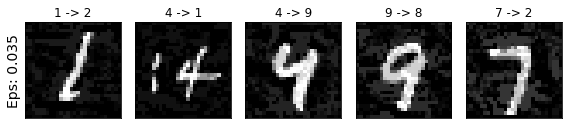

In [88]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

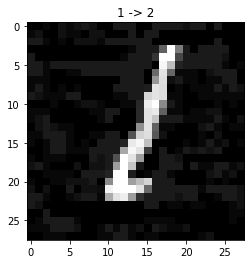

In [90]:
orig_fix, adv_fix, restore_pic = examples[0][0]
plt.title("{} -> {}".format(orig_fix, adv_fix))
plt.imshow(restore_pic, cmap='gray')

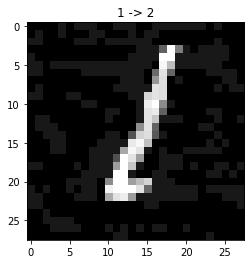

In [128]:
# Gets Example pic and makes it a tensor
orig_fix, adv_fix, restore_pic = examples[0][0]        
plt.title("{} -> {}".format(orig_fix, adv_fix))
fix_pic = torch.tensor(restore_pic)

# Finds number of pixels to be fixed using top % and bottom %
# val_count = restore_pic.size*.05
# val_count = int(val_count)
# val_count_bot = val_count

# #Gets the above number of pixels and their indexes
# top_half, top_half_idx = torch.topk(fix_pic.flatten(), val_count)
# top_half_list = np.array(np.unravel_index(top_half_idx.numpy(), fix_pic.shape)).T
# top_min = top_half.min()

# bot_half, bot_half_idx = torch.topk(fix_pic.flatten(), val_count_bot, largest=False)
# bot_half_list = np.array(np.unravel_index(bot_half_idx.numpy(), fix_pic.shape)).T
# bot_max = bot_half.max()

# #Transforms the above pixels into their respective valus
# for x, y in top_half_list:
#     fix_pic[x][y] = torch.max(fix_pic.flatten())
# for x, y in bot_half_list:
#     fix_pic[x][y] = torch.min(fix_pic.flatten())

# print(torch.std(fix_pic))
stand_dev = torch.std(fix_pic)
avg = torch.mean(fix_pic)
# print(avg)
# avg = torch.tensor(.5)

# for x, a in enumerate(fix_pic):
#     for y, b in enumerate(a):
#         if(b.item()>=avg and b.item()<=(avg+stand_dev)):
#             fix_pic[x][y] = avg+stand_dev
#             # b = 1
#         elif(b.item()<=avg and b.item()>=(avg-stand_dev)):
#             # b = bot_max
#             fix_pic[x][y] = avg-stand_dev

for x, a in enumerate(fix_pic):
    for y, b in enumerate(a):
        if(b.item()<=avg+(-.19*stand_dev)):
            # b = bot_max
            fix_pic[x][y] = 0
            # fix_pic[x][y] = avg-(stand_dev*.03)
        elif(b.item()<avg+(stand_dev)):
            fix_pic[x][y] = avg-(stand_dev*.03)
        # elif(b.item()>avg+(stand_dev)):
        #     fix_pic[x][y] = avg+(stand_dev)
            # fix_pic[x][y] = 1

plt.imshow(fix_pic, cmap='gray')
fix_pic = fix_pic.unsqueeze(dim=0)
fix_pic = fix_pic.unsqueeze(dim=0)
# print(fix_pic)

In [443]:
# print(fix_pic)

In [20]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img, device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds
    # return yb

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [129]:
print(predict_image(fix_pic, model))

tensor([2])


In [105]:
model.eval()
result_thing = model(fix_pic)
print(result_thing)
m = nn.Softmax(dim=1)
print(m(result_thing))

tensor([[-2.5398, -1.7363, -1.3233, -2.6612, -2.9872, -2.8905, -2.6520, -2.7008,
         -2.0725, -3.2363]], grad_fn=<LogSoftmaxBackward>)
tensor([[0.0789, 0.1762, 0.2663, 0.0699, 0.0504, 0.0555, 0.0705, 0.0672, 0.1259,
         0.0393]], grad_fn=<SoftmaxBackward>)


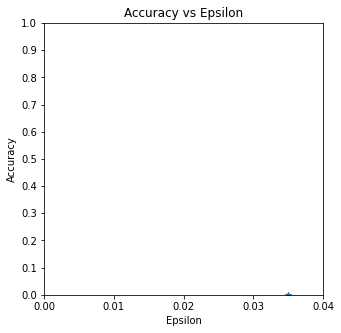

In [292]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, epsilons[-1] + .01, step=.01))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [82]:
orig, adv, img = examples[3][3]
plt.imshow(img, cmap='gray')
print("Original: ", orig, "\nAdversarial:", adv)

IndexError: list index out of range

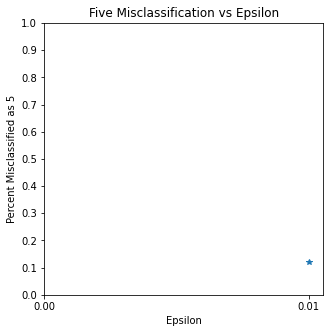

In [83]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, five_misclass, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, epsilons[-1] + .01, step=.01))
plt.title("Five Misclassification vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Percent Misclassified as 5")
plt.show()

In [139]:
images = []
for j in range(10):    
    data = torch.zeros((1,1,28,28)).to(device)
    data.requires_grad = True
    output = model(data)
    for i in range(10000):
        loss = F.cross_entropy(output, torch.tensor([j]).to(device))
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data.sign()
        perturbed_image = data - .001*data_grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        data = perturbed_image.clone().detach()
        data.requires_grad_()
        output = model(data)

    img = perturbed_image.squeeze().detach().cpu().numpy()
    images.append(img)

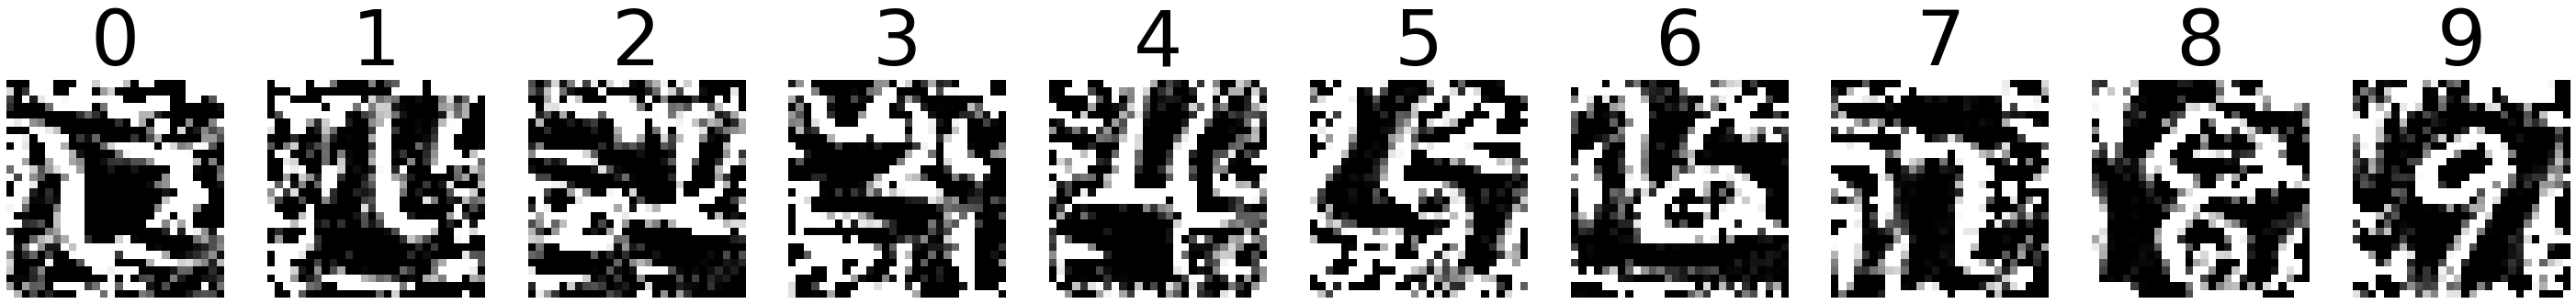

In [154]:
plt.figure(figsize=(50,50))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.title(i, fontsize = '84')
    plt.imshow(images[i], cmap='gray')
plt.savefig('perfect-numbers.jpg')

In [210]:
dl = torch.utils.data.DataLoader(torch.tensor(images), batch_size=1)
total = np.zeros(10)
for x, batch in enumerate(dl):
    batch = batch.unsqueeze(0)
    batch = batch.to(device)
    output = model(batch)
    s = nn.Softmax(dim=1)
    output = s(output)
    output = output.cpu().detach().numpy().squeeze(0)
    total = np.add(output, total)
    total[x] = total[x] - output[x]

print(total)

[6.74815533e-05 2.36971938e-04 2.99823884e-03 1.57925741e-03
 1.44184915e-03 7.52807357e-04 8.51656917e-04 9.90923407e-04
 1.37785629e-03 4.27575052e-04]
